JITコンパイル中...
コンパイル完了。
計算中...
計算完了: 0.0264 秒


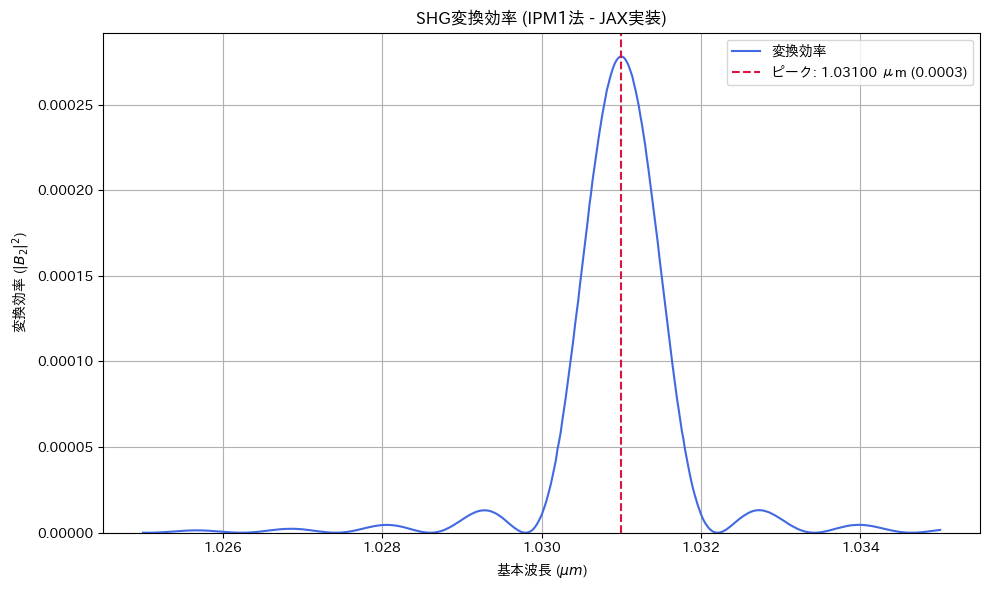

In [1]:
import jax.numpy as jnp
from jax import jit, vmap, lax
import matplotlib.pyplot as plt
import japanize_matplotlib
import time

# --- 定数設定 ---
Z_MAX = 2000  # デバイス長 (μm)
KAPPA_MAG = 1.31e-5  # 非線形結合係数
DESIGN_TEMP_C = 70.0  # 設計温度 (°C)
DESIGN_WAVELENGTH = 1.031  # 設計波長 (μm)

# --- Sellmeier方程式のパラメータ ---
SELLMEIER_PARAMS = {
    'a': jnp.array([4.5615, 0.08488, 0.1927, 5.5832, 8.3067, 0.021696]),
    'b': jnp.array([4.782e-07, 3.0913e-08, 2.7326e-08, 1.4837e-05, 1.3647e-07])
}


@jit
def sellmeier_n_eff(wl: jnp.ndarray, temp: jnp.ndarray) -> jnp.ndarray:
    """Sellmeier方程式を用いて実効屈折率を計算"""
    f = (temp - 24.5) * (temp + 24.5 + 2.0 * 273.16)
    lambda_sq = wl**2
    a, b = SELLMEIER_PARAMS['a'], SELLMEIER_PARAMS['b']
    n_sq = (a[0] + b[0] * f +
            (a[1] + b[1] * f) / (lambda_sq - (a[2] + b[2] * f)**2) +
            (a[3] + b[3] * f) / (lambda_sq - (a[4] + b[4] * f)**2) -
            a[5] * lambda_sq)
    return jnp.sqrt(n_sq)


@jit
def get_delta_k(wl1: jnp.ndarray, wl2: jnp.ndarray, t: jnp.ndarray) -> jnp.ndarray:
    """位相不整合量を計算"""
    wl_sum = (wl1 * wl2) / (wl1 + wl2)
    n1, n2, n_sum = sellmeier_n_eff(wl1, t), sellmeier_n_eff(
        wl2, t), sellmeier_n_eff(wl_sum, t)
    return 2.0 * jnp.pi * (n_sum / wl_sum - n1 / wl1 - n2 / wl2)


@jit
def get_L(delta_k1: jnp.ndarray, delta_k2: jnp.ndarray) -> jnp.ndarray:
    """線形演算子Lに対応する対角行列の要素を返す"""
    return 1j * jnp.array([0.0, delta_k1, delta_k1 + delta_k2], dtype=jnp.complex64)


@jit
def phi(omega: jnp.ndarray, h: float) -> jnp.ndarray:
    """
    IPM1予測子で使用される積分関数 Φ(Ω, h) = (e^(Ωh) - 1) / Ω を計算する。
    JAXのjitに対応するため、jnp.whereで条件分岐を処理する。
    """
    is_small = jnp.abs(omega) < 1e-9
    val_small = h + h**2 * omega / 2.0
    val_large = (jnp.exp(omega * h) - 1.0) / omega
    return jnp.where(is_small, val_small, val_large)


@jit
def predictor_ipm1(B_in: jnp.ndarray, h: float, kappa_val: float, L: jnp.ndarray) -> jnp.ndarray:
    """
    IPM1 (Interaction Picture Method 1st order) スキームの1ステップを計算する。
    (周波数項の計算を最適化)
    """
    B1n, B2n, B3n = B_in
    L1, L2, L3 = L

    omega_a = L2 - 2 * L1
    omega_b = L3 - L2 - L1

    delta_B_NL1 = 1j * kappa_val * jnp.exp(L1 * h) * (
        jnp.conj(B1n) * B2n * phi(omega_a, h) +
        jnp.conj(B2n) * B3n * phi(omega_b, h)
    )
    delta_B_NL2 = 1j * kappa_val * jnp.exp(L2 * h) * (
        B1n**2 * phi(-omega_a, h) +
        2 * jnp.conj(B1n) * B3n * phi(omega_b, h)
    )
    delta_B_NL3 = 1j * 3 * kappa_val * jnp.exp(L3 * h) * (
        B1n * B2n * phi(-omega_b, h)
    )
    delta_B_NL = jnp.array([delta_B_NL1, delta_B_NL2, delta_B_NL3])

    B_pred = jnp.exp(L * h) * B_in + delta_B_NL
    return B_pred


def generate_superlattice(z_max: float, qpm_k: float, kappa_mag: float) -> jnp.ndarray:
    """周期的な符号反転ドメイン構造（超格子）をJAXの配列として生成する"""
    if jnp.abs(qpm_k) < 1e-9:
        return jnp.array([[z_max, kappa_mag]])

    # 周期は 2π/Δk。ドメイン長はその半分の π/Δk
    domain_length = jnp.pi / qpm_k

    # ドメインの境界点を計算
    boundaries = jnp.arange(domain_length, z_max, domain_length)
    all_points = jnp.unique(jnp.concatenate(
        [jnp.array([0.0]), boundaries, jnp.array([z_max])]))

    # 各ドメインの長さ(h)と結合係数(kappa)を計算
    h_values = jnp.diff(all_points)
    signs = (-1.0)**jnp.arange(h_values.shape[0])
    kappa_values = kappa_mag * signs

    return jnp.stack([h_values, kappa_values], axis=1)


def simulate_single_wavelength(wavelength: float, temperature: float, superlattice: jnp.ndarray) -> jnp.ndarray:
    """指定された単一の波長に対して、lax.scanを用いて伝播計算を実行する"""
    B_initial = jnp.array([1.0, 0.0, 0.0], dtype=jnp.complex64)

    # 位相不整合量を計算
    delta_k1 = get_delta_k(wavelength, wavelength, temperature)
    delta_k2 = get_delta_k(wavelength, wavelength / 2.0, temperature)
    L = get_L(delta_k1, delta_k2)

    # lax.scanに渡すためのステップ関数を定義
    def ipm1_scan_step(B_carry, domain):
        h, kappa_val = domain
        B_next = predictor_ipm1(B_carry, h, kappa_val, L)
        # (次の状態, 各ステップの出力) を返す
        return B_next, None

    # scanを実行して最終状態B_finalを取得
    B_final, _ = lax.scan(ipm1_scan_step, B_initial, superlattice)

    # SHG効率 |B2|^2 を返す
    return jnp.abs(B_final[1])**2


def run_and_plot():
    """シミュレーションを実行し、結果をプロットする"""
    # パラメータ設定
    wavelengths = jnp.linspace(1.025, 1.035, 501)
    temperature = DESIGN_TEMP_C

    # 設計波長・温度におけるQPM波数ベクトルを計算
    qpm_k = get_delta_k(DESIGN_WAVELENGTH, DESIGN_WAVELENGTH, temperature)

    # QPM格子を一度だけ生成
    superlattice = generate_superlattice(Z_MAX, qpm_k, KAPPA_MAG)

    # vmapを用いて波長方向に計算を並列化し、jitでコンパイル
    vmapped_propagate = jit(
        vmap(simulate_single_wavelength, in_axes=(0, None, None)))

    print("JITコンパイル中...")
    # 一度ダミー実行してコンパイルを完了させる
    vmapped_propagate(wavelengths, temperature,
                      superlattice).block_until_ready()
    print("コンパイル完了。")

    print("計算中...")
    start_time = time.time()
    efficiencies = vmapped_propagate(wavelengths, temperature, superlattice)
    efficiencies.block_until_ready()  # 計算完了を待つ
    total_time = time.time() - start_time
    print(f"計算完了: {total_time:.4f} 秒")

    # 結果のプロット
    peak_idx = jnp.argmax(efficiencies)
    peak_wl = wavelengths[peak_idx]
    peak_eff = efficiencies[peak_idx]

    plt.figure(figsize=(10, 6))
    plt.plot(wavelengths, efficiencies, label="変換効率", color='royalblue')
    plt.axvline(x=float(peak_wl), color='crimson', linestyle='--',
                label=f"ピーク: {peak_wl:.5f} μm ({peak_eff:.4f})")
    plt.xlabel(r"基本波長 ($\mu m$)")
    plt.ylabel(r"変換効率 ($|B_2|^2$)")
    plt.title("SHG変換効率 (IPM1法 - JAX実装)")
    plt.legend()
    plt.grid(True)
    plt.ylim(bottom=0)
    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    run_and_plot()